In [1]:
%matplotlib notebook
import numpy as np
import json, glob
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from ipyfilechooser import FileChooser

### Choose the json file:

In [2]:
fc = FileChooser('/sf/alvra/data/p19470/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


FileChooser(path='/sf/alvra/data/p19470/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [ ]:
import numpy as np
from bsread import source, Source
from scipy.interpolate import interp1d
from scipy import signal
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d
from epics import caput, PV
from datetime import datetime
from scipy import optimize
import matplotlib.pyplot as plt

ROI_background = 'SARES11-SPEC125-M2.roi_background_x_profile'
ROI_signal = 'SARES11-SPEC125-M2.roi_signal_x_profile'
ROI_signal_baby = 'SARES11-SPEC125-M1.roi_signal_x_profile'
Events = 'SAR-CVME-TIFALL4:EvtSet'
IZero = 'SAROP11-PBPS117:INTENSITY'
Channels = [ROI_background, ROI_signal, ROI_signal_baby, Events, IZero]
shutter = PV('SARFE10-OPSH059:REQUEST')

#spectrometer wavelength calibration / frequency conversion
lambdas = 467.55 + 0.07219*np.arange(0,2047) # calibration from 23-9-2020
lambdas_baby = 528.34 + 0.0261*np.arange(0,2047) # calibration from 06-10-2021 on the small kymera 
nus = 299792458 / (lambdas * 10**-9) # frequency space, uneven
nus_baby = 299792458 / (lambdas_baby * 10**-9) # frequency space, uneven, baby
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True) # frequency space, even
nus_new_baby = np.linspace(nus_baby[0], nus_baby[-1], num=2047, endpoint=True) # frequency space, even, baby
pixelNum = np.arange(0,2047)

def measure(nshots, chans):

    pulse_ids = np.empty(nshots)
    events = np.empty((nshots, 256))
    backgrounds = np.empty((nshots, 2047))
    signals = np.empty((nshots, 2047))
    signals_baby = np.empty((nshots, 2047))
    iZeros = np.empty(nshots)

    stream = Source(channels=chans)
    stream.connect()

    ntotal = 0
    i = 0
    while i < nshots:
        ntotal += 1
        try:
            message = stream.receive()
        except Exception as e:
            print(type(e).__name__, e)
            while True:
                try:
                    stream = Source(channels=chans)
                    stream.connect()
                except Exception as e2:
                    print(type(e2).__name__, e2)
                else:
                    break

        data = message.data.data

        sig =  data[ROI_signal].value
        sig_baby = data[ROI_signal_baby].value
        back = data[ROI_background].value
        i0 = data[IZero].value
        evs = data[Events].value
        if (sig is None) or (sig_baby is None) or (back is None) or (evs is None) or (i0 is None):
            continue
        pulse_ids[i] = message.data.pulse_id
        events[i] = evs
        backgrounds[i] = back
        signals[i] = sig
        signals_baby[i] = sig_baby
        iZeros[i] = i0
        i += 1
        
    stream.disconnect()

    timeofdata = datetime.now()
    print('Good shots: {} out of a total {} requested'.format(nshots, ntotal))
#    print(f'Good shots: {ngood} out of a total {ntotal} requested')

    return pulse_ids, events, backgrounds, signals, signals_baby, iZeros

filters = {
    "YAG": np.concatenate((np.ones(50),signal.tukey(40)[20:40], np.zeros(1977), np.zeros(2047))), # fourier filter for YAGS
    "SiN": np.concatenate((signal.tukey(40)[20:40], np.zeros(2027), np.zeros(2047))), # fourier filter for 5um SiN
    "SiN2": np.concatenate((signal.tukey(32)[16:32], np.zeros(2031), np.zeros(2047))) # fourier filter for 2um SiN
}

Heaviside = np.concatenate((np.zeros(100), np.ones(100)))

def edge(filter_name, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    edge positions determined from argmax of peak traces
    signal traces, should show a change in transmission near px 1024 if set up correctly
    peak traces, which are the derivative of signal traces
    """

    ffilter = filters[filter_name]
    # background subtraction
    sig2 = np.nan_to_num(signals / backgrounds) / background_from_fit
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus, sig2, kind='cubic')
    sig3 = sig3inter(nus_new)
    sig4 = np.hstack((sig3, np.zeros_like(sig3)))
    # Fourier transform, filter, inverse fourier transform, take the real part, take the derivative (sig5gaussO1)
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * ffilter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4inter = interp1d(nus_new, sig4invreal[..., 0:2047], kind='cubic')
    sig5 = sig4inter(nus)

    # transmissive edges, not used, just for plotting if you like.
    sig5gaussO0 = gaussian_filter1d(sig5, 30)
    sig6 = convolve1d(sig5gaussO0, Heaviside)
    # peaks
    sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
    peak2 = np.argmax(sig5gaussO1, axis = -1)

    return peak2, sig6, sig5gaussO1

def goodshots(events, *arrays):
    fel = events[:, 13]
    laser = events[:, 18]
    darkShot = events[:, 21]
    good_shots = np.logical_and.reduce((fel, laser, np.logical_not(darkShot)))
    return [a[good_shots] for a in arrays]

def lasershots(events, *arrays):
    fel = events[:, 13]
    laser = events[:, 18]
    darkShot = events[:, 21]
    laser_shots = np.logical_and.reduce((laser, np.logical_not(darkShot)))
    return [a[laser_shots] for a in arrays]

def polyfxn(x, a, b, c, d, e, f, g, h):
    return a*x**7 + b*x**6 + c*x**5 + d*x**4 + e*x**3 + f*x**2 + g*x + h

def background(filter_name):
    # measure w/o FEL
    shutter.put(0)
    _, events, backgrounds, signals, signals_baby, _ = measure(100, Channels)
    shutter.put(1)

    offset_background, offset_signal, background_avg_baby = np.mean(lasershots(events, backgrounds, signals, signals_baby), axis=1)
    background_avg = offset_signal/offset_background

    fitBackground, _ = optimize.curve_fit(polyfxn, lambdas, background_avg, p0=[1, 1, 1, 1, 1, 1, 1 ,1])
    fitBackground_baby, _ = optimize.curve_fit(polyfxn, lambdas_baby, background_avg_baby, p0=[1, 1, 1, 1, 1, 1, 1 ,1])
    background_from_fit = polyfxn(lambdas, *fitBackground)
    background_from_fit_baby = polyfxn(lambdas_baby, *fitBackground_baby)

    _, _, peakback = edge(filter_name, background_from_fit, background_avg, 1, 0)
    _, _, peakback_baby = edge(filter_name, background_from_fit_baby, background_avg_baby, 1, 0)

    plt.ion()
    plt.figure(figsize=(8,8))
    plt.subplot(311)
    plt.plot(offset_signal, label = 'sig')
    plt.plot(offset_background, label = 'bkg')
    plt.legend(loc='best')
    plt.xlim(0,2047)

    plt.subplot(312)
    plt.plot(background_avg, label='raw')
    plt.plot(background_from_fit, label='fit')
    plt.plot(background_avg/background_from_fit, label='corrected')
    plt.plot(background_avg_baby, label='baby')
    plt.plot(background_from_fit_baby, label='fit baby')
    plt.plot(background_avg_baby/background_from_fit_baby, label='corrected baby')
    plt.xlabel('pixel')
    plt.legend(loc='best')
    plt.xlim(0,2047)
    plt.ylim(0.5, 2.5)
    plt.grid()

    plt.subplot(313)
    plt.plot(peakback*10000, color='black', label='peak background')
    plt.legend(loc='best')%%!
    plt.xlim(0,2047)
    plt.ylim(-10, 10)
    plt.show()

    return background_from_fit, peakback, background_from_fit_baby, peakback_baby

def jitterMonitor(filter_name, nshots, px2fs, background_from_fit, peakback):

    pulse_ids, events, backgrounds, signals, _, iZeros = measure(nshots, Channels)
    back, sig = goodshots(events, backgrounds, signals)
    edgePos, sigtraces, peaktraces = edge(filter_name, back, sig, background_from_fit, peakback)
    timeofdata =  datetime.now()

    plt.ion()
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.title(timeofdata)
    plt.axvline(x=1024, color='r')
    plt.hist(edgePos, bins=20)
    plt.xlim(800, 1200)
    plt.xlabel('pixel')

    sigtraces = sigtraces[:, 0:2047]
    sigtraces_normal = sigtraces / np.max(sigtraces, axis=-1)[:, np.newaxis] * 100

    plt.subplot(122)
    for i in range(40):
        plt.plot(pixelNum, np.roll(sigtraces_normal[i], -75))
        plt.plot(pixelNum, (peaktraces[i]) * 11500)
    plt.axvline(x=1024, color='r')
    plt.xlabel ('pixel')
    plt.xlim(700, 1300)
    plt.ylim(-10, 110)
    plt.title("Offset of {} fs, jitter of {} fs rms".format(np.round(((1024 - np.mean(edgePos))*px2fs),2), np.round((np.std(edgePos)*px2fs),2)))

    plt.grid()
    plt.show()



In [3]:
import pathlib

from scipy.interpolate import interp1d
from scipy.signal import tukey
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import convolve1d

#spectrometer wavelength calibration / frequency conversion
lambdas = 467.55 + 0.07219*np.arange(0,2047) # calibration from 23-9-2020
lambdas_baby = 528.34 + 0.02610*np.arange(0,2047) # calibration from 06-10-2021 on the small kymera
nus = 299792458 / (lambdas * 10**-9) # frequency space, uneven
nus_baby = 299792458 / (lambdas_baby * 10**-9) # frequency space, uneven
nus_new = np.linspace(nus[0], nus[-1], num=2047, endpoint=True) # frequency space, even
nus_new_baby = np.linspace(nus_baby[0], nus_baby[-1], num=2047, endpoint=True) # frequency space, even
pixelNum = np.arange(0,2047)
filters = {
    "YAG": np.concatenate((np.ones(50),tukey(40)[20:40], np.zeros(1977), np.zeros(2047))), # fourier filter for YAGS
    "SiN": np.concatenate((tukey(40)[20:40], np.zeros(2027), np.zeros(2047))) # fourier filter for 5um SiN
}
Heaviside = np.concatenate((np.zeros(100), np.ones(100)))

def arrivalTimes(filter_name, px2fs, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    arrival times in fs determined from argmax of peak traces and the calibration px2fs
    amplitudes of the peak traces
    signal traces, should show a change in transmission near px 1024 if set up correctly
    peak traces, which are the derivative of signal traces
    """

    p0 = 1024
    ffilter = filters[filter_name]
    # background subtraction
    sig2 = np.nan_to_num(signals / backgrounds) / background_from_fit
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus, sig2, kind='cubic')
    sig3 = sig3inter(nus_new)
    sig4 = np.hstack((sig3, np.zeros_like(sig3)))
    # Fourier transform, filter, inverse fourier transform, take the real part, take the derivative (sig5gaussO1)
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * ffilter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4inter = interp1d(nus_new, sig4invreal[..., 0:2047], kind='cubic')
    sig5 = sig4inter(nus)
    
    # transmissive edges, not used, just for plotting if you like.
    sig5gaussO0 = gaussian_filter1d(sig5, 30)
    sig6 = convolve1d(sig5gaussO0, Heaviside)
    # peaks
    sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
    arrivalTimes = (p0 - np.argmax(sig5gaussO1, axis = -1))*px2fs
    arrivalAmplitudes = np.max(sig5gaussO1, axis = -1) * 11500    
    
    return arrivalTimes, arrivalAmplitudes, sig6, sig5gaussO1

def arrivalTimes_baby(filter_name, px2fs, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    arrival times in fs determined from argmax of peak traces and the calibration px2fs
    amplitudes of the peak traces
    signal traces, should show a change in transmission near px 1024 if set up correctly
    peak traces, which are the derivative of signal traces
    """

    p0 = 1024
    ffilter = filters[filter_name]
    # background subtraction
    sig2 = np.nan_to_num(signals / backgrounds) / background_from_fit
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus_baby, sig2, kind='cubic')
    sig3 = sig3inter(nus_new_baby)
    sig4 = np.hstack((sig3, np.zeros_like(sig3)))
    # Fourier transform, filter, inverse fourier transform, take the real part, take the derivative (sig5gaussO1)
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * ffilter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4inter = interp1d(nus_new_baby, sig4invreal[..., 0:2047], kind='cubic')
    sig5 = sig4inter(nus_baby)
    
    # transmissive edges, not used, just for plotting if you like.
    sig5gaussO0 = gaussian_filter1d(sig5, 30)
    sig6 = convolve1d(sig5gaussO0, Heaviside)
    # peaks
    sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
    arrivalTimes = (p0 - np.argmax(sig5gaussO1, axis = -1))*px2fs
    arrivalAmplitudes = np.max(sig5gaussO1, axis = -1) * 11500    
    
    return arrivalTimes, arrivalAmplitudes, sig6, sig5gaussO1

def _get_base_folder(fname):
    fname = fname.split(os.sep)
    return os.sep.join(fname[:5])

def find_backgrounds(fname, path):
    fpath = pathlib.Path(fname)
    fmtime = fpath.stat().st_mtime

    background_path = _get_base_folder(fname) + path
    background_path = pathlib.Path(background_path)

    background = None
    peak_background = None
    min_time_diff1 = float('inf')
    min_time_diff2 = float('inf')
    for entry in background_path.iterdir():
        if entry.is_file() and 'psen-background' in entry.name:
            pmtime = entry.stat().st_mtime
            time_diff1 = abs(pmtime - fmtime)
            if time_diff1 < min_time_diff1:
                min_time_diff1 = time_diff1
                background = entry
        elif entry.is_file() and 'psen-peak-background' in entry.name:    
            pmtime = entry.stat().st_mtime
            time_diff2 = abs(pmtime - fmtime)
            if time_diff2 < min_time_diff2:
                min_time_diff2 = time_diff2
                peak_background = entry

    return background, peak_background, fmtime

def edge(filter_name, backgrounds, signals, background_from_fit, peakback):
    """
    returns:
    edge positions determined from argmax of peak traces
    signal traces, should show a change in transmission near px 1024 if set up correctly
    peak traces, which are the derivative of signal traces
    """

    ffilter = filters[filter_name]
    # background subtraction
    sig2 = np.nan_to_num(signals / backgrounds) / background_from_fit
    # interpolate to get evenly sampled in frequency space
    sig3inter = interp1d(nus, sig2, kind='cubic')
    sig3 = sig3inter(nus_new)
    sig4 = np.hstack((sig3, np.zeros_like(sig3)))
    # Fourier transform, filter, inverse fourier transform, take the real part, take the derivative (sig5gaussO1)
    sig4fft = np.fft.fft(sig4)
    sig4filtered = sig4fft * ffilter
    sig4inverse = np.fft.ifft(sig4filtered)
    sig4invreal = 2 * np.real(sig4inverse)
    sig4inter = interp1d(nus_new, sig4invreal[..., 0:2047], kind='cubic')
    sig5 = sig4inter(nus)

    # transmissive edges, not used, just for plotting if you like.
    sig5gaussO0 = gaussian_filter1d(sig5, 30)
    sig6 = convolve1d(sig5gaussO0, Heaviside)
    # peaks
    sig5gaussO1 = gaussian_filter1d(sig5, 50, order = 1) - peakback
    peak2 = np.argmax(sig5gaussO1, axis = -1)

    return peak2, sig6, sig5gaussO1

In [6]:
def YAG_scan_two_TT_new(json_file, channel_delay_motor, timezero_mm, quantile, 
                        target_1, calibration_1, target_2, calibration_2,
                        filterTime_1=2000, filterAmp_1=0, filterTime_2=2000, filterAmp_2=0):
    
    channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_motor,
                      channel_PSEN_signal, channel_PSEN_bkg,
                      channel_cam125_signal]
    channel_list_all = channel_list_pp

    ########################################################################

    from sfdata import SFScanInfo
    scan = SFScanInfo(json_file)
    
    Delay_fs_stage = []
    Pump_probe = []
    Pump_probe_scan = []
    arrTimes_1_scan = []
    arrTimesAmp_1_scan = []
    arrTimes_2_scan = []
    arrTimesAmp_2_scan = []
    Delays_fs_scan = []
    
    arrTimes_1_std = []
    arrTimes_2_std = []
    
    for i, step in enumerate(scan):
        check_files_and_data(step)
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Processing: {}'.format(json_file.split('/')[-1]))
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
        
        resultsPP, results_FEL, _, _ = load_data_compact_FEL_pump(channel_list_pp, channel_list_all, step)

        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump
        sig_1 = resultsPP[channel_PSEN_signal].pump
        back_1 = resultsPP[channel_PSEN_bkg].pump
        sig_2 = resultsPP[channel_cam125_signal].pump
        back_2 = resultsPP[channel_cam125_signal].unpump
        
        delay_shot = resultsPP[channel_delay_motor].pump
        delay_shot_fs = mm2fs(delay_shot, timezero_mm)
        Delay_fs_stage.append(delay_shot_fs.mean())

        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
        bkg_files = find_backgrounds(step.fnames[0],'/scratch')
        print ("File recorded at {}".format(datetime.fromtimestamp(bkg_files[2])))
        print (bkg_files[0])
        print (bkg_files[1])
        background_from_fit_1 = np.loadtxt(bkg_files[0])
        peakback_1 = np.loadtxt(bkg_files[1])
        _, _, peakback_2 = edge(target_2, back_2[0], back_2[0], 1, 0)
            
        arrTimes_1, arrTimesAmp_1, sigtraces_1, peaktraces_1 = arrivalTimes(target_1, calibration_1, back_1, sig_1, background_from_fit_1, peakback_1)
        arrTimes_2, arrTimesAmp_2, sigtraces_2, peaktraces_2 = arrivalTimes_baby(target_2, calibration_2, back_2, sig_2, 1, peakback_2)
        
        index_1 = (np.asarray(arrTimes_1) < filterTime_1) & (np.asarray(arrTimesAmp_1) > filterAmp_1)
        index_2 = (np.asarray(arrTimes_2) < filterTime_2) & (np.asarray(arrTimesAmp_2) > filterAmp_2)
        
        index = np.logical_and.reduce((index_1, index_2))
        
        Delays_fs_scan.append(delay_shot_fs[index])
        arrTimes_1_scan.append(arrTimes_1[index])
        arrTimesAmp_1_scan.append(arrTimesAmp_1[index])
        arrTimes_2_scan.append(arrTimes_2[index] -175)
        arrTimesAmp_2_scan.append(arrTimesAmp_2[index])
        Pump_probe_scan.append(Laser_diff[index])
        
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile/2, 0.5 + quantile/2]))
    
    
    Delays_fs_scan = np.asarray(list(itertools.chain.from_iterable(Delays_fs_scan)))
    arrTimes_1_scan = np.asarray(list(itertools.chain.from_iterable(arrTimes_1_scan)))
    arrTimesAmp_1_scan = np.asarray(list(itertools.chain.from_iterable(arrTimesAmp_1_scan)))
    arrTimes_2_scan = np.asarray(list(itertools.chain.from_iterable(arrTimes_2_scan)))
    arrTimesAmp_2_scan = np.asarray(list(itertools.chain.from_iterable(arrTimesAmp_2_scan)))
    
    Pump_probe_scan = np.asarray(list(itertools.chain.from_iterable(Pump_probe_scan)))
    
    Delays_fs_scan = np.asarray(Delays_fs_scan)
    arrTimes_1_scan = np.asarray(arrTimes_1_scan)
    arrTimesAmp_1_scan = np.asarray(arrTimesAmp_1_scan)
    arrTimes_2_scan = np.asarray(arrTimes_2_scan)
    arrTimesAmp_2_scan = np.asarray(arrTimesAmp_2_scan)
    Pump_probe_scan = np.asarray(Pump_probe_scan)
    Pump_probe = np.asarray(Pump_probe)
    
    Delays_corr_1_scan = Delays_fs_scan + arrTimes_1_scan#((p0 - np.array(edgePos))*px2fs)
    Delays_corr_2_scan = Delays_fs_scan + arrTimes_2_scan#((p0 - np.array(edgePos))*px2fs)
    
    print ("Quantile range = {}".format(0.5 - quantile/2), 0.5 + quantile/2)
    print ("Loaded {} files, size of the arrays = {}".format(len(scan.files), len(Pump_probe)))
    
    return Delay_fs_stage, Delays_corr_1_scan, Delays_corr_2_scan, Pump_probe, Pump_probe_scan, arrTimes_1_scan, arrTimes_2_scan, arrTimesAmp_1_scan, arrTimesAmp_2_scan

In [7]:
quantile_band = 0.5

channel_delay_motor = channel_delay_topas
timezero_mm = 203.705    ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)

targetM2 = 'YAG'
px2fsM2 = 2.044

targetM1 = 'SiN'
px2fsM1 = 1.957

filterTimeM1 = 2000
filterAmpM1 = 0

########################################
#YAG_scan_one_TT(json_file, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
########################################

# Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
# YAG_scan_one_TT(fc.selected, channel_delay_motor, timezero_mm, quantile_band, target, px2fs)

########################################
#YAG_scan_two_TT(json_file, channel_delay_motor, timezero_mm, quantile, 
#                    target_1, calibration_1, target_2, calibration_2,
#                    filterTime_1=2000, filterAmp_1=0, filterTime_2=2000, filterAmp_2=0):
########################################

Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan, arrTimes_M2, arrTimes_M1, arrAmp_M2, arrAmp_M1 = YAG_scan_two_TT_new(fc.selected, channel_delay_motor, timezero_mm, quantile_band, targetM2, px2fsM2, targetM1, px2fsM1,2000, 0, filterTimeM1, filterAmpM1)

pp_uncorrected = Pump_probe[:,0]
err_pp_low = Pump_probe[:,1]
err_pp_high = Pump_probe[:,2]

Processing: YAG_scan_loop_PSEN__001.json
Step 41 of 41: Processing run_000997
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               502 / 502 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 502 / 502 -> 0% loss
complete channels: 7 / 7 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-10-07 19:36:41.656966
/sf/alvra/data/p19470/scr

Arr.time STD M2:   39.414642534423955
Arr.time STD M1:   734.3848981054123


/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


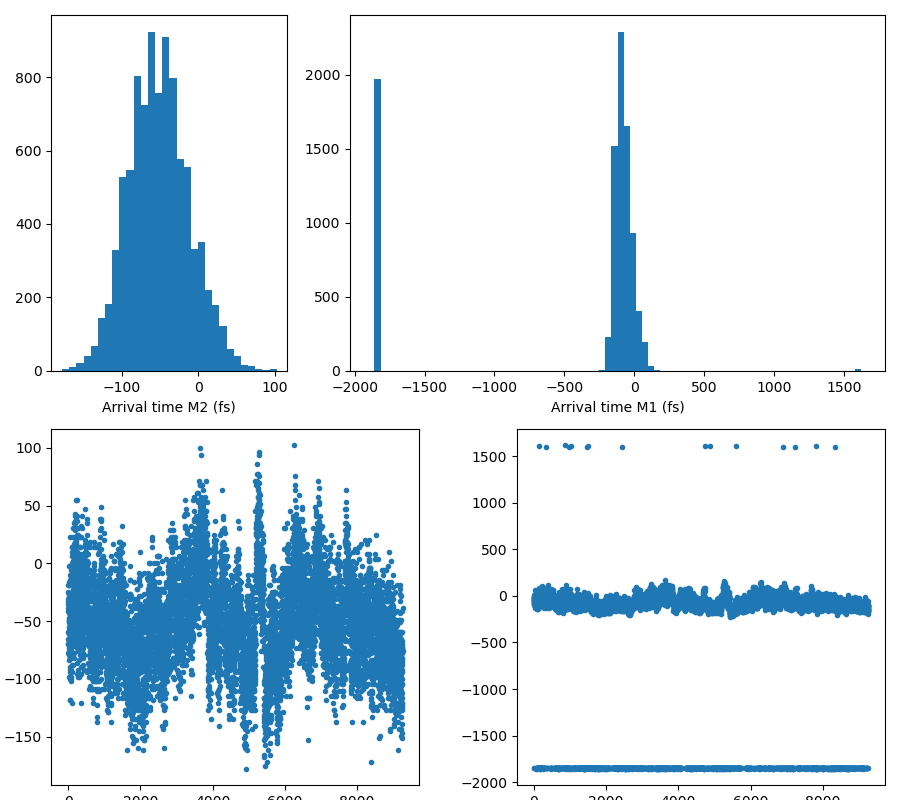

<ipython-input-9-df4899d3327a>:19: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


In [9]:
print('Arr.time STD M2:  ', np.std(arrTimes_M2))
print('Arr.time STD M1:  ', np.std(arrTimes_M1))

plt.figure(figsize=(9,8))
plt.subplot(231)
plt.hist(arrTimes_M2, 30)
plt.xlabel('Arrival time M2 (fs)')
plt.subplot(2,3,(2,3))
plt.hist(arrTimes_M1, 80)
plt.xlabel('Arrival time M1 (fs)')
plt.tight_layout()

plt.subplot(2,2,3)
plt.plot(arrTimes_M2, '.')

plt.subplot(2,2,4)
plt.plot(arrTimes_M1, '.')

plt.tight_layout()
plt.show()

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


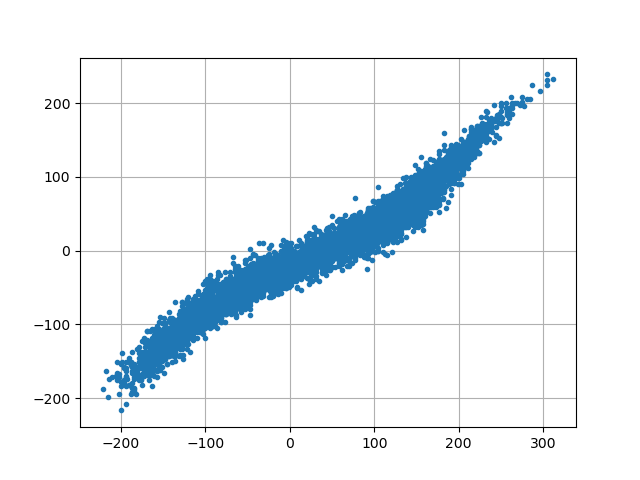

In [349]:
plt.figure()
plt.plot(arrTimes_M1, arrTimes_M2, '.')

#plt.xlim(-175, 150)
#plt.ylim(-225, 175)
plt.grid()



/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


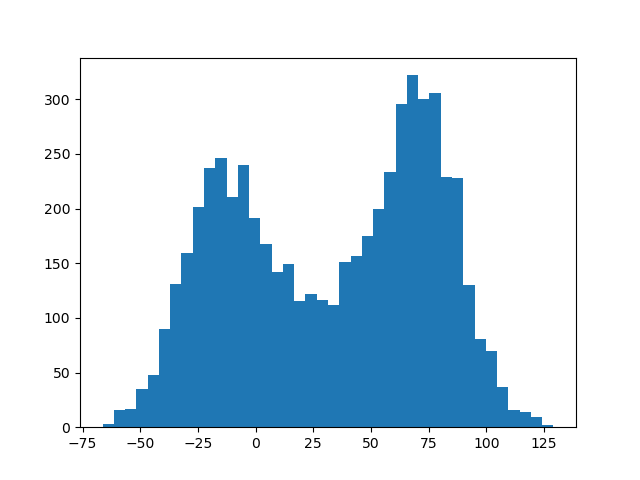

In [350]:
plt.figure()
plt.hist(arrTimes_M1 - arrTimes_M2, bins=40)
plt.show()

## Re-bin the data with chosen binsize

In [351]:
binsize = 10 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

binList = np.arange(Delay_fs[0] +260, Delay_fs[-1] +100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] +260 + binsize/2, Delay_fs[-1] +100 - binsize/2, binsize)

pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

(5705,) (5705,) (5705,)


## Choose fit function

In [352]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
# fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
# fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit for the first TT

In [353]:
index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
pp_TT_M2 =  pp_TT_M2[index_M2]

fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting

t0_fs_M2 = fit.popt[0]
t0_mm_M2 = timezero_mm + fs2mm(t0_fs_M2, 0)
width_fs_M2 = fit.popt[2]

## Do the fit for the second TT

In [354]:
index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))
Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
pp_TT_M1 =  pp_TT_M1[index_M1]

fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting

t0_fs_M1 = fit.popt[0]
t0_mm_M1 = timezero_mm + fs2mm(t0_fs_M1, 0)
width_fs_M1 = fit.popt[2]

## Plot

<IPython.core.display.Javascript object>


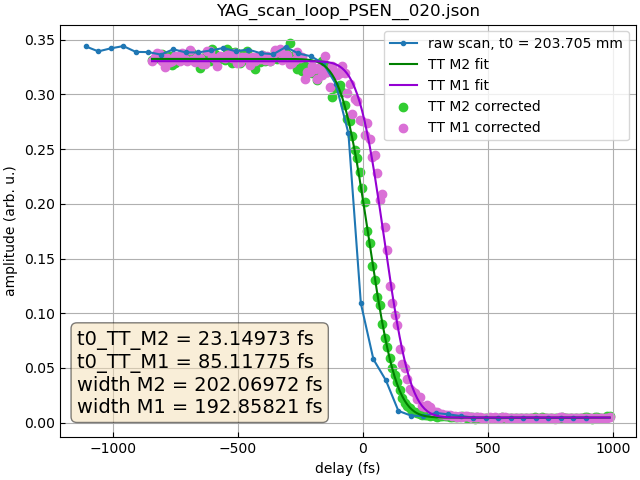

In [355]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.title(fc.selected_filename)
plt.tick_params(direction='in')

#plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format((np.round(timezero_mm, 5))))
plt.scatter(Delay_fs_TT_M2, pp_TT_M2, color='limegreen', label = 'TT M2 corrected')
plt.scatter(Delay_fs_TT_M1, pp_TT_M1, color='orchid', label = 'TT M1 corrected')
plt.plot(Delay_fs_TT_M2, pp_fit_M2, color='green', label = 'TT M2 fit')
plt.plot(Delay_fs_TT_M1, pp_fit_M1, color='darkviolet', label = 'TT M1 fit')


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0_TT_M2 = {} fs'.format(np.round(t0_fs_M2, 5)),
                     r't0_TT_M1 = {} fs'.format(np.round(t0_fs_M1, 5)),
            r'width M2 = {} fs'.format(np.abs(np.round(width_fs_M2, decimals = 5))),
            r'width M1 = {} fs'.format(np.abs(np.round(width_fs_M1, decimals = 5)))))
plt.text(0.03, 0.06, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.grid()
plt.show()


# Loop over several runs

In [330]:
datafiles = []
for file in glob('/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN_*.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = np.delete(datafiles[:122], [64,108,109])
patch

array(['/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__001.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__002.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__003.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__004.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__005.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__006.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__007.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__008.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__009.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__010.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__011.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__012.json',
       '/sf/alvra/data/p19470/raw/scan_info/YAG_scan_loop_PSEN__013.json',
       '/sf/alvra/data/p1

In [362]:
quantile_band = 0.5
binsize = 10

channel_delay_motor = channel_delay_topas
timezero_mm = 203.705

targetM2 = 'YAG'
px2fsM2 = 2.044

targetM1 = 'SiN'
px2fsM1 = 1.957*0.5

filterTimeM1 = 700
filterAmpM1 = 6.6

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

# t0_fs_M2_scan =[]
# width_fs_M2_scan = []
# t0_fs_M1_scan =[]
# width_fs_M1_scan = []

for json_file in patch:
    print (json_file)
    scan = SFScanInfo(json_file)
    
    Delay_fs, Delays_corr_M2, Delays_corr_M1, Pump_probe, Pump_probe_scan = \
    YAG_scan_two_TT_new(json_file, channel_delay_motor, timezero_mm, quantile_band, \
                    targetM2, px2fsM2, targetM1, px2fsM1, \
                    2000, 0, filterTimeM1, filterAmpM1)
    
    print (np.shape(Pump_probe_scan),np.shape(Delays_corr_M2), np.shape(Delays_corr_M1))

    binList = np.arange(Delay_fs[0] +260, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] +260 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT_M2, binEdges, binNumber = binned_statistic(Delays_corr_M2, Pump_probe_scan, statistic='mean', bins=binList)
    pp_TT_M1, binEdges, binNumber = binned_statistic(Delays_corr_M1, Pump_probe_scan, statistic='mean', bins=binList)

    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index_M2 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M2))
    index_M1 = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT_M1))

    Delay_fs_TT_M2 = Delay_fs_TT[index_M2]
    Delay_fs_TT_M1 = Delay_fs_TT[index_M1]
    pp_TT_M2 =  pp_TT_M2[index_M2]
    pp_TT_M1 =  pp_TT_M1[index_M1]
    
    ############################################################

    fit.estimate(Delay_fs_TT_M2, pp_TT_M2)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

    fit.fit(Delay_fs_TT_M2,pp_TT_M2)                  # calculate the fit
    pp_fit_M2 = fit.eval(Delay_fs_TT_M2)           # evaluate the curve for plotting
    
    t0_fs_M2 = fit.popt[0]
    width_fs_M2 = fit.popt[2]
    
    ############################################################
    
    fit.estimate(Delay_fs_TT_M1, pp_TT_M1)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 

    fit.fit(Delay_fs_TT_M1,pp_TT_M1)                  # calculate the fit
    pp_fit_M1 = fit.eval(Delay_fs_TT_M1)           # evaluate the curve for plotting
    
    t0_fs_M1 = fit.popt[0]
    width_fs_M1 = fit.popt[2]
    
    ############################################################
    
    t0_fs_M2_scan.append(t0_fs_M2)
    width_fs_M2_scan.append(width_fs_M2)
    t0_fs_M1_scan.append(t0_fs_M1)
    width_fs_M1_scan.append(width_fs_M1)

Processing: YAG_scan_loop_PSEN__122.json
Step 41 of 41: Processing run_005965
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                     483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS                  483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET               483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET               483 / 483 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 483 / 483 -> 0% loss
complete channels: 7 / 7 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-10-08 07:57:27.698692
/sf/alvra/data/p19470/scr

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


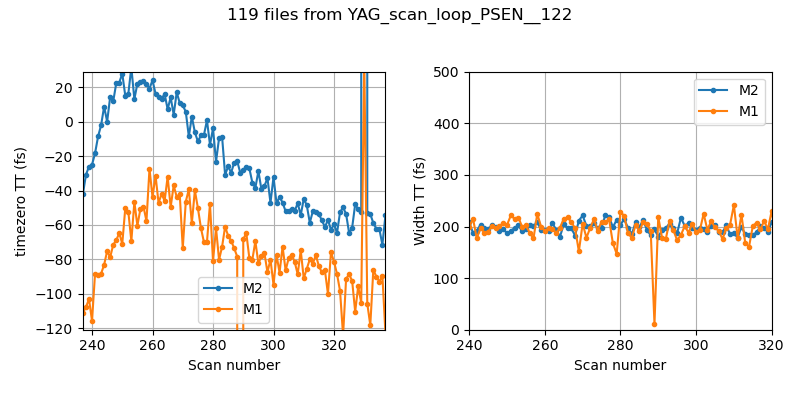

In [378]:
plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-1].split('.')[0]))

plt.subplot(121)
plt.plot(t0_fs_M2_scan, marker='.', label='M2')
plt.plot(np.asarray(t0_fs_M1_scan), marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel('Scan number')
plt.ylabel('timezero TT (fs)')
plt.ylim(-100,50)
plt.xlim(220,320)
plt.grid()

plt.subplot(122)
plt.plot(width_fs_M2_scan, marker='.', label='M2')
plt.plot(np.asarray(width_fs_M1_scan), marker='.', label='M1')
plt.legend(loc='best')
plt.xlabel("Scan number")
plt.ylabel('Width TT (fs)')
plt.ylim(0,500)
plt.xlim(240,320)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [334]:
np.shape(t0_fs_M2_scan)

/sf/alvra/anaconda/alvra-analysis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(237,)

<IPython.core.display.Javascript object>


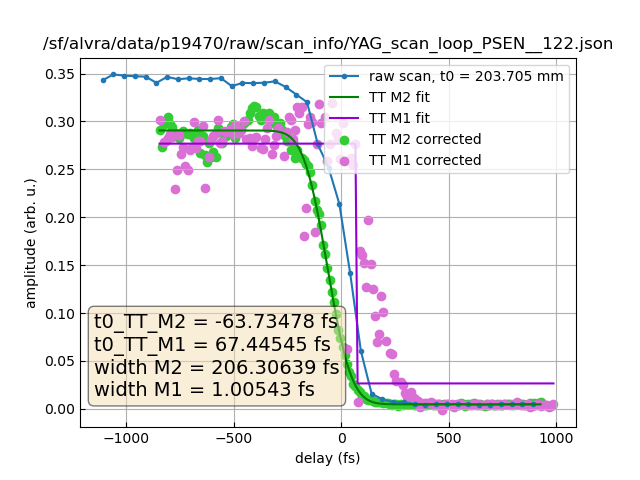

In [213]:
plt.figure()

plt.title(json_file)
plt.tick_params(direction='in')

#plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')
plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format((np.round(timezero_mm, 5))))
plt.scatter(Delay_fs_TT_M2, pp_TT_M2, color='limegreen', label = 'TT M2 corrected')
plt.scatter(Delay_fs_TT_M1, pp_TT_M1, color='orchid', label = 'TT M1 corrected')
plt.plot(Delay_fs_TT_M2, pp_fit_M2, color='green', label = 'TT M2 fit')
plt.plot(Delay_fs_TT_M1, pp_fit_M1, color='darkviolet', label = 'TT M1 fit')


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r't0_TT_M2 = {} fs'.format(np.round(t0_fs_M2, 5)),
                     r't0_TT_M1 = {} fs'.format(np.round(t0_fs_M1, 5)),
            r'width M2 = {} fs'.format(np.abs(np.round(width_fs_M2, decimals = 5))),
            r'width M1 = {} fs'.format(np.abs(np.round(width_fs_M1, decimals = 5)))))
plt.text(0.06, 0.1, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.grid()
plt.show()


##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19161/raw/scan_info/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19161/raw/scan_info', filename='', show_hidden='False')

In [3]:
targetM2 = 'YAG'
px2fsM2 = 2.2054

targetM1 = 'YAG'
px2fsM1 = 1.957

arrTimes_M2, arrTimesAmp_M2, arrTimes_M2_scan, arrTimesAmp_M2_scan, peaktraces_M2,\
arrTimes_M1, arrTimesAmp_M1, arrTimes_M1_scan, arrTimesAmp_M1_scan, peaktraces_M1 = \
Two_TT_statistics_scan(fc.selected,  targetM2, px2fsM2, targetM1, px2fsM1)


Processing: timescan_YAG_loop_22.json
Step 41 of 41: Processing run_002573
Pump rep rate (FEL) is 50.0 Hz
Probe rep rate (laser) is 100.0 Hz

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_background_x_profile 250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M2.roi_signal_x_profile     250 / 250 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 250 / 250 -> 0% loss
complete channels: 4 / 4 -> 0% incomplete

--------------------------------------------------------------------------------

File recorded at 2021-05-06 03:07:38.097397
/sf/alvra/data/p19161/scratch/2021-05-07-13:02-psen-background.txt
/sf/alvra/data/p19161/scratch/2021-05-07-13:02-psen-peak-background.txt


<IPython.core.display.Javascript object>


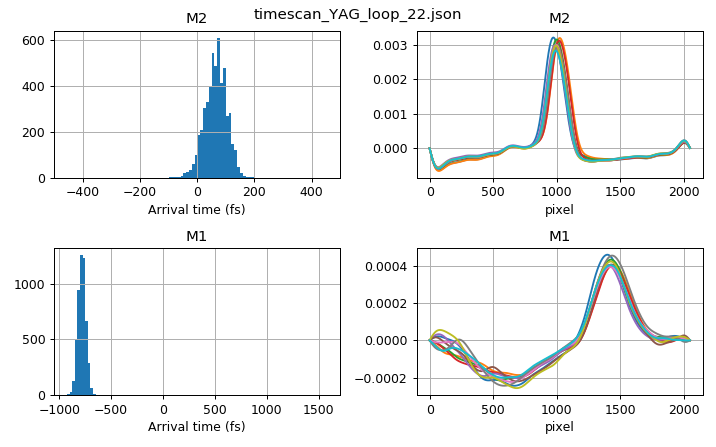

M2
Statistics on all (5106,) shots of the scan
Offset compared to pixel 1048 is 65.34652894633764 fs
Jitter, i.e. width (std) of the histogram 37.830723822592574 fs
--------------------------------------------------------------
Statistics on (125,) shots of the last step of the scan
Offset compared to pixel 1048 is 53.95290560000001 fs
Jitter, i.e. width (std) of the histogram 37.451348265606256 fs
**************************************************************
M1
Statistics on all (5106,) shots of the scan
Offset compared to pixel 1048 is -781.105159811986 fs
Jitter, i.e. width (std) of the histogram 49.8186706454013 fs
--------------------------------------------------------------
Statistics on (125,) shots of the last step of the scan
Offset compared to pixel 1048 is -784.2246960000001 fs
Jitter, i.e. width (std) of the histogram 36.40177903327781 fs


In [10]:
plt.figure(figsize = (8,5))
plt.suptitle (fc.selected_filename)

plt.subplot(221)
plt.title('M2')
plt.hist(arrTimes_M2_scan, bins=30)
plt.grid()
plt.xlim(-500,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(222)
plt.title('M2')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M2[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.subplot(223)
plt.title('M1')
plt.hist(arrTimes_M1_scan, bins=100)
plt.grid()
#plt.xlim(-1000,0)
plt.xlabel('Arrival time (fs)')

plt.subplot(224)
plt.title('M1')
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces_M1[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()

plt.tight_layout()
plt.show()

print("M2")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M2_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M2)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M2)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M2)))
print("**************************************************************")
print("M1")
print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_M1_scan)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes_M1)))
print("Offset compared to pixel 1048 is {} fs".format(np.mean(arrTimes_M1)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_M1)))
